In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer


#from tensorflow.keras.models import Model
#from tensorflow.keras.models import load_model
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#from tensorflow.keras.layers import TextVectorization
#from tensorflow.keras.optimizers import *

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Import Data

In [2]:
df = pd.read_csv("labeled_data.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Tokenizer

Tokenize all words contained in the Tweets of the Dataset.

The Tweets are stored in the dataframe df (column "tweet")

In [4]:
#Split String for each word
def toLowerAndSplit(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    return tweet

In [5]:
tweets = pd.DataFrame(df["tweet"].apply(toLowerAndSplit))

In [6]:
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"


In [7]:
#Create a list containing all words mentioned in tweets
all_words = list(itertools.chain(*tweets["tweet"]))

## Count Words

In [8]:
# Count of every word
word_counts = Counter(all_words)

df_uncleaned = pd.DataFrame(word_counts.most_common(10))


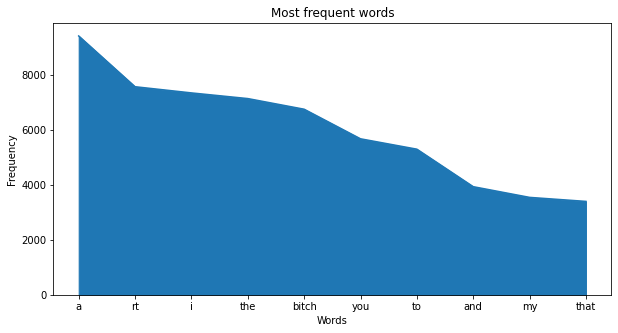

In [9]:
df_uncleaned.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_uncleaned.index)), df_uncleaned[0])
plt.show()

## Remove stopwords

To gain more substantial insight into the data, stopwords such as "i", "a", "at", "the" have to be removed. These words construct the grammatical dependencies of the english language, but do not contain any relevant information to determine hate speech.

## Remove Tags

Twitter tags such as @genericUser do not give further insight for hate speech detection purposes. Thus, they have to be removed.

## Remove Links

Similar to stopwords and Tags, links do not add meaningfull information to the purpose of hate speech --> remove

## Remove Twitter Elements

The Tweets can contain Twitter excluvsive information, such as "rt", "rts" or "retweet". These formulations do not add any meaning to the Tweets content and have therefore to be removed.

In [10]:
#Uncomment if nltk stopwords were not downloaded yet
#nltk.download('stopwords')

In [11]:
#Define variable wit henglish stopwords
sw = stopwords.words("english")
twitter_elements = ["rt", "rts", "retweet"]
most_common = word_counts.most_common()



def removeNoiseWordCount(word_list):
    cleaned_word_list = []
    for element in word_list:
        #Removes words contained in stopwords
        if element[0] not in sw:
            #Removes words with @ --> remove Tags
            if "@" not in element[0]: 
                #Removes words containing http --> links
                if "http" not in element[0]:
                    hasTwitterElement = False
                    for tw in twitter_elements:
                        if tw in element:
                            hasTwitterElement = True
                    if hasTwitterElement == False:
                        cleaned_word_list.append(element)

    return cleaned_word_list

In [12]:
cleaned_word_list_complete = removeNoiseWordCount(most_common)

In [13]:
df_cleaned_top10 = pd.DataFrame(cleaned_word_list_complete[:10])

In [14]:
df_cleaned_top10

,0,1
0,bitch,6749
1,bitches,2677
2,like,2674
3,hoes,1977
4,pussy,1731
5,i'm,1552
6,hoe,1483
7,ass,1472
8,get,1413
9,fuck,1311


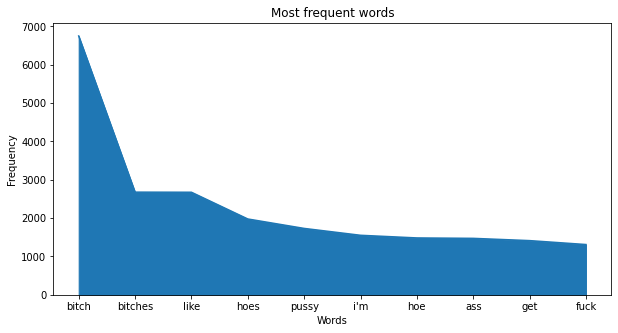

In [15]:
df_cleaned_top10.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_cleaned_top10.index)), df_cleaned_top10[0])
plt.show()

In [47]:
def removeNoiseFromTweet(word_list):
    cleaned_word_list = []
    for element in word_list:
        for word in element:
            #Removes words contained in stopwords
            if word not in sw:
                #Removes words with @ --> remove Tags
                if "@" not in word: 
                    #Removes words containing http --> links
                    if "http" not in word:
                        hasTwitterElement = False
                        #Removes Twitter exclusive Words (retweet/ rt...) 
                        for tw in twitter_elements:
                            if tw in word:
                                hasTwitterElement = True
                        if hasTwitterElement == False:
                            #Remove special characters from string
                            cleaned_word = ""
                            cleaned_word = "".join(character for character in word if character.isalnum())
                            if cleaned_word != "":
                                cleaned_word_list.append(cleaned_word)
        return cleaned_word_list

In [48]:
#Apply the removeNoiseFromTweet function with axis = 1 --> compute for every row
cleaned_words_df = tweets.apply(func=removeNoiseFromTweet, axis=1)

In [49]:
#Cleaned pandas series element 
cleaned_words_df

0        [woman, complain, cleaning, house, amp, man, a...
1        [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2           [dawg, ever, fuck, bitch, cry, confused, shit]
3                                     [look, like, tranny]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [yous, muthafin, lie, right, tl, trash, 8230, ...
24779    [gone, broke, wrong, baby, drove, redneck, crazy]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781             [youu, got, wild, bitches, tellin, lies]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

# Word Stems

To further ensure high data quality, we should remove plural words from the pool (e.g. in plot above: bitch/ bitches currently are seperate entities at this point). 

In [19]:
#Remove Comment when running the first time
#nltk.download('punkt')

In [20]:
stemmer = PorterStemmer()
def stemWords(tweet):
    word_stems = []
    for word in tweet:
        
        word_stems.append(stemmer.stem(word))
        
    return word_stems

In [21]:
word_stems = cleaned_words_df.apply(stemWords)

In [22]:
word_stems

0        [woman, complain, clean, hous, amp, man, alway...
1        [boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...
2             [dawg, ever, fuck, bitch, cri, confus, shit]
3                                     [look, like, tranni]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [you, muthafin, lie, right, tl, trash, 8230, n...
24779    [gone, broke, wrong, babi, drove, redneck, crazi]
24780    [young, buck, wanna, eat, dat, nigguh, like, a...
24781                [youu, got, wild, bitch, tellin, lie]
24782    [ruffl, ntac, eileen, dahlia, beauti, color, c...
Length: 24783, dtype: object

In [23]:
#Create a list containing all words mentioned in tweets
stem_words = list(itertools.chain(*word_stems))

In [24]:
# Count of every word
word_counts_stem = Counter(stem_words)

df_stem = pd.DataFrame(word_counts_stem.most_common(10))


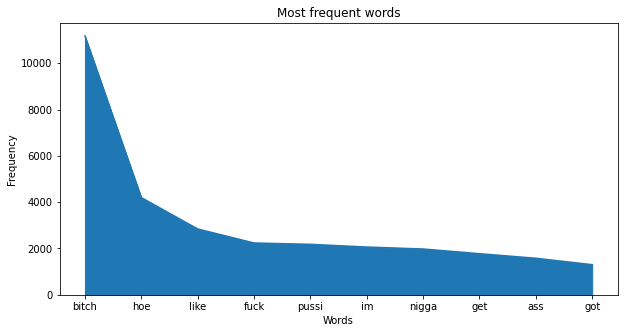

In [25]:
df_stem.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_stem.index)), df_stem[0])
plt.show()

## Model Training

In [26]:
#change elements of column from list to string
def makeString(column):
    result = " ".join(column)
    return result

In [27]:
word_stems_text = word_stems.apply(makeString)

In [28]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(word_stems_text, df["class"], test_size=0.2, shuffle=True, random_state=10)

In [29]:
#x_train_tok = [nltk.word_tokenize(i) for i in X_train]
#x_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [30]:
X_train

700           dutch peopl live outsid newyorkc white trash
3015                          bitch like it mean someth me
9011                  everyon tell exact thing listen coon
10395    gotta admit use tell bitch everyth want hear b...
8422     charli crist outlaw hate redicul vilifi shake ...
                               ...                        
9372                               gabbi bitch two account
7291                                        dark ie nig ok
17728                  cant believ bitch find remot appeal
7293     perfect stock photographi let leprechaunlook h...
17673    bitch eyebrow 5 hair 95 makeup talkin bout 822...
Length: 19826, dtype: object

In [31]:
#Benötigt von Logistic Regression
tfid = TfidfVectorizer(lowercase=False)
x_train_vec = tfid.fit_transform(X_train)
x_test_vec = tfid.transform(X_test)

In [32]:
x_train_vec

<19826x17874 sparse matrix of type '<class 'numpy.float64'>'
	with 147811 stored elements in Compressed Sparse Row format>

In [33]:
#When C < 1 --> better results
lr = LogisticRegression(solver="liblinear", penalty="l2", C=1)

In [34]:
lr.fit(x_train_vec, y_train)

LogisticRegression(C=1, solver='liblinear')

In [35]:
y_predict = lr.predict(x_test_vec)

In [36]:
y_prob = lr.predict_proba(x_test_vec)[:,1]

In [37]:
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.64      0.14      0.23       285
           1       0.90      0.98      0.94      3815
           2       0.88      0.77      0.82       857

    accuracy                           0.89      4957
   macro avg       0.81      0.63      0.66      4957
weighted avg       0.88      0.89      0.88      4957

[[  39  219   27]
 [  21 3731   63]
 [   1  198  658]]


# Rumprobieren

In [50]:
vectorize_layer = TextVectorization(
 max_tokens=None,
 output_mode='int',
 output_sequence_length=100)

In [73]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = vectorize_layer(inputs)
x = layers.Embedding(1, 1)(x)
#x = layers.Conv2D(filters=32, kernel_size=(5, 5))(x)

x = layers.Dropout(0.5)(x)

x = layers.Dense(5)(x)
x = layers.Dense(5)(x)
x = layers.Dense(5)(x)



# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="Huber", optimizer="adam", metrics=["accuracy"])

In [74]:
model.fit(X_train,
          y_train, 
          epochs=30)

Epoch 1/30
620/620 [==============================] - 7s 10ms/step - loss: 0.1640 - accuracy: 0.7545
Epoch 2/30
620/620 [==============================] - 6s 10ms/step - loss: 0.1151 - accuracy: 0.7702
Epoch 3/30
620/620 [==============================] - 6s 10ms/step - loss: 0.1100 - accuracy: 0.7800
Epoch 4/30
620/620 [==============================] - 6s 9ms/step - loss: 0.1089 - accuracy: 0.7822
Epoch 5/30
620/620 [==============================] - 6s 9ms/step - loss: 0.1139 - accuracy: 0.7722
Epoch 6/30
620/620 [==============================] - 6s 9ms/step - loss: 0.1123 - accuracy: 0.7754
Epoch 7/30
620/620 [==============================] - 6s 10ms/step - loss: 0.1128 - accuracy: 0.7743
Epoch 8/30
620/620 [==============================] - 5s 7ms/step - loss: 0.1144 - accuracy: 0.7713
Epoch 9/30
620/620 [==============================] - 5s 9ms/step - loss: 0.1125 - accuracy: 0.7750
Epoch 10/30
620/620 [==============================] - 6s 9ms/step - loss: 0.1119 - accuracy: 0.

In [ ]:
df_2

In [ ]:
np.asarray(c)

In [ ]:
c